In [1]:
import json

import torch
import numpy as np
import matplotlib.pyplot as plt
import transformers

from collections import defaultdict #, Counter
from transformers import AutoModelForMaskedLM, AutoTokenizer

from operator import mul
from functools import reduce

device = 'cuda:0'
softmax = torch.nn.Softmax(dim=-1)
torch.manual_seed(0)
np.random.seed(0)

MODEL_NAME = 'xlm-roberta-large'
MASK_TOKEN = '<mask>'
PAD_TOKEN = '<pad>'
BOS_TOKEN = '<s>'
EOS_TOKEN = '</s>'

KWORDS_THING = ('hiçbir şey','hiçbir şey','hiçbir şey','hiçbir şey',)
KWORDS_BODY  = ('kimseyi','kimseyi','kimseyi','kimseyi',)
INPUT_FILE = 'tr_test_sentences_newwords.tsv'

PREFIX = 'tr_xlmr'

BATCH_SIZE = 40 
assert BATCH_SIZE%4 == 0, '# important to have BATCH_SIZE%4 == 0'

RANDOM_TOKENS = 40

keywords = list(set(KWORDS_THING)|set(KWORDS_BODY))


tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_tokens(['[NOT]','[FEW]','[MANY]'], special_tokens=True)

model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
device = torch.device('cuda:0')
model.to(device)
reverse_vocab = {y:x for x, y in tokenizer.vocab.items()}

2021-11-15 22:47:28.137130: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# let's check the number of tokens in our keywords

torch.manual_seed(0)
np.random.seed(0)

keywords2tokens = dict()

for keyword in keywords:
    tokens = tokenizer.tokenize(keyword)
    keywords2tokens[keyword] = tokens
#     keywords2random_tokens[keyword] = np.random.choice(range(max(reverse_vocab)), (TEST_CASES_PER_SIZE,len(tokens)))
    print(len(tokens), tokens)

random_tokens = dict()
for tok in ('[NOT]', '[FEW]', '[MANY]'):
    random_tokens[tok] = np.random.choice(range(max(reverse_vocab)), RANDOM_TOKENS)

2 ['▁kimse', 'yi']
2 ['▁hiçbir', '▁şey']


In [3]:
random_tokens

{'[NOT]': array([199340,  43567, 173685, 117952, 176963, 152315,  95939,  97639,
         41993, 122579,  86293, 186098, 112420, 211543, 212038,  48600,
        170584,  52620,  80186,  17089, 163302, 150055, 108631, 247982,
        220760, 101201,  82457, 224077, 235592, 137993, 169876,  67699,
         70608, 168691,   7877,  83966, 132943,  73135, 133568, 179026]),
 '[FEW]': array([155747, 108504,  31921, 230131, 131869,  49811, 199827, 211854,
        221607, 122144, 212929, 183561,  84665, 119423,  41504,  49866,
        215284, 123031, 125603, 227838,  11723, 174962, 148663,  58146,
        108672, 223360, 190372,  89141,  71557, 151078, 134632, 221940,
         61713,  96591,  45444, 247401,  46522, 113183,  86904,  20737]),
 '[MANY]': array([159719, 192425,  92217,  80163,  12134, 191607,  47883, 237998,
         86107,  63360, 182883,   9781, 150412,  27257, 147370,  12372,
        248011, 135492, 111366, 236484,  82991,  62079, 210932, 234627,
        138084,   9396, 243688, 

In [4]:
# parse, mask, tokenize

subj_dict = dict()
verb_dict = dict()

def mask_sent(sent, kword):
    return [BOS_TOKEN,] + tokenizer.tokenize( 
        sent.replace(kword, f'{MASK_TOKEN} '*len(keywords2tokens[kword])).replace('  ',' ') 
    ) + [EOS_TOKEN,]

tokenized_array = []
metadata_array = []

lines = [line for idx, line in enumerate(open(INPUT_FILE, encoding='utf-8'))]

np.random.seed(0)
np.random.shuffle(lines)

for idx, line in enumerate(lines):
    chunks = line.strip().split()
    tchunks = line.strip().split('\t')

    if chunks[-1]=='thing':
        kwords = KWORDS_THING
    else:
        kwords = KWORDS_BODY
    
    subj_id = int(chunks[-3])
    subject = chunks[1]
    subj_dict[subj_id] = subject
    verb_id = int(chunks[-2])
    verb1 = chunks[2]
    verb2 = chunks[8]
    verb_dict[verb_id] = (verb1, verb2)
    
    for tidx, (cl,kword) in enumerate( zip( ('aff', 'neg', 'many', 'few'), kwords ) ):
        mt_sent = mask_sent(tchunks[tidx], kword)
        tokenized_array.append( mt_sent )
        metadata_array.append( 
            (
                (cl, subj_id, verb_id, kword, chunks[-1]),
                (tchunks[tidx], mt_sent)
            )
        )


In [5]:
def assess_batch(batch, metas, r_idx):
    global scores
    batch_input_ids = []
    batch_segment_ids = []
    
    mask_positions = []
    mask_lens = []

    max_len = max(map(len,batch))
#     print('#', max_len, ' ', end='')
    
    for idx, s in enumerate(batch):
        mask_positions.append( s.index(MASK_TOKEN) )
        mask_lens.append( s.count(MASK_TOKEN) )
        
        input_ids = tokenizer.convert_tokens_to_ids(s + [PAD_TOKEN,]*(max_len-len(s)))
        for tok in ('[NOT]', '[FEW]', '[MANY]'): # replace spec tokens with random ones
            if tok in s:
                input_ids[s.index(tok)] = random_tokens[tok][r_idx]

        batch_input_ids.append( input_ids )
        batch_segment_ids.append( [0] * len(input_ids) )

    input_ids = torch.tensor(batch_input_ids, dtype=torch.long).to(device)
    segment_ids = torch.tensor(batch_segment_ids, dtype=torch.long).to(device)
    logits = model(input_ids, token_type_ids=segment_ids)[0]
    probs = softmax(logits)
    
    return [
        reduce(mul, [pr[pos+t_pos][tokenizer.vocab[tok]].cpu().detach().numpy() \
            for t_pos, tok in enumerate(keywords2tokens[meta[0][3]]) ], 1. ) \
                for pr, pos, meta in zip(probs, mask_positions, metas)
    ]
        
assess_batch(tokenized_array[128*4:130*4], metadata_array[126*4:130*4], 1)

[8.45531961761145e-09,
 5.84695820150318e-08,
 1.1760420045588407e-08,
 1.553315460398358e-09,
 3.7341018216308135e-07,
 3.064900606595027e-08,
 1.3110784357134074e-07,
 1.8332684053554713e-06]

In [6]:
# assess all the sentences

scores = defaultdict(list)
for b_idx, idx in enumerate(range(0, len(tokenized_array), BATCH_SIZE)):
    if not idx%200: print(f'{idx/(len(tokenized_array)):.2%}')
#     print(idx,idx+BATCH_SIZE)
#     print(tokenized_array[idx:idx+BATCH_SIZE])
    scores[b_idx%RANDOM_TOKENS].extend( assess_batch(tokenized_array[idx:idx+BATCH_SIZE], 
                                                     metadata_array[idx:idx+BATCH_SIZE], 
                                                     b_idx%RANDOM_TOKENS) ) # here we select the set of random tokens

0.00%
0.50%
1.00%
1.50%
2.00%
2.50%
3.00%
3.50%
4.00%
4.50%
5.00%
5.50%
6.00%
6.50%
7.00%
7.50%
8.00%
8.50%
9.00%
9.50%
10.00%
10.50%
11.00%
11.50%
12.00%
12.50%
13.00%
13.50%
14.00%
14.50%
15.00%
15.50%
16.00%
16.50%
17.00%
17.50%
18.00%
18.50%
19.00%
19.50%
20.00%
20.50%
21.00%
21.50%
22.00%
22.50%
23.00%
23.50%
24.00%
24.50%
25.00%
25.50%
26.00%
26.50%
27.00%
27.50%
28.00%
28.50%
29.00%
29.50%
30.00%
30.50%
31.00%
31.50%
32.00%
32.50%
33.00%
33.50%
34.00%
34.50%
35.00%
35.50%
36.00%
36.50%
37.00%
37.50%
38.00%
38.50%
39.00%
39.50%
40.00%
40.50%
41.00%
41.50%
42.00%
42.50%
43.00%
43.50%
44.00%
44.50%
45.00%
45.50%
46.00%
46.50%
47.00%
47.50%
48.00%
48.50%
49.00%
49.50%
50.00%
50.50%
51.00%
51.50%
52.00%
52.50%
53.00%
53.50%
54.00%
54.50%
55.00%
55.50%
56.00%
56.50%
57.00%
57.50%
58.00%
58.50%
59.00%
59.50%
60.00%
60.50%
61.00%
61.50%
62.00%
62.50%
63.00%
63.50%
64.00%
64.50%
65.00%
65.50%
66.00%
66.50%
67.00%
67.50%
68.00%
68.50%
69.00%
69.50%
70.00%
70.50%
71.00%
71.50%
72.00%
72.50

In [7]:
np.array(scores).shape
len(scores)
len(scores[39])

# shape of score is [random_tokens_idx][ (aff_prob, neg_prob, many_prob, few_prob)*items ]

1000

In [8]:
stats = defaultdict(lambda:defaultdict(lambda:defaultdict(list)))

for r_idx in range(RANDOM_TOKENS):
    for score, meta in zip(scores[r_idx], metadata_array):
        if meta[0][0]=='aff':
            handle = (meta[0][4], 'aff>neg')
            k_idx = 0
        if meta[0][0]=='neg':
            handle = (meta[0][4], 'aff>neg')
            k_idx = 1
        if meta[0][0]=='many':
            handle = (meta[0][4], 'many>few')
            k_idx = 0
        if meta[0][0]=='few':
            handle = (meta[0][4], 'many>few')
            k_idx = 1
        handle2 = ('both', handle[1])
        stats[handle][r_idx][k_idx].append( score )
        stats[handle2][r_idx][k_idx].append( score )

# shape of stats now is
#  [handles][random_tokens_idx][(0 for aff and many, 1 for neg and few)][items]
# where handle is one of ('body', 'aff>neg'), ('body', 'many>few'), ('both', 'aff>neg'), 
#                          ('both', 'many>few'), ('thing', 'aff>neg'), ('thing', 'many>few')

In [9]:
measures = dict()
for handle in sorted(stats):
    r = []
    for r_idx in range(RANDOM_TOKENS):
        r.append( np.count_nonzero(list(map(lambda x:x[0]>x[1], zip(stats[handle][r_idx][0],stats[handle][r_idx][1]))))/len(stats[handle][r_idx][0]) )
    print(handle, f'  mean {np.mean(r):0.3%} std {np.std(r):0.3%}')
    measures[handle] = r[:]
    
# shape of measures is 
#   [handles][ random_tokens_idx scores ]

('body', 'aff>neg')   mean 74.481% std 10.486%
('body', 'many>few')   mean 47.662% std 11.893%
('both', 'aff>neg')   mean 74.370% std 10.042%
('both', 'many>few')   mean 47.970% std 10.833%
('thing', 'aff>neg')   mean 74.193% std 10.397%
('thing', 'many>few')   mean 48.464% std 10.430%


dict_keys([('body', 'aff>neg'), ('body', 'many>few'), ('both', 'aff>neg'), ('both', 'many>few'), ('thing', 'aff>neg'), ('thing', 'many>few')])

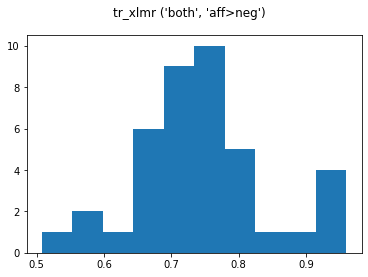

In [10]:
# r
plt.hist(measures[('both', 'aff>neg')])
plt.suptitle(PREFIX+' '+str(('both', 'aff>neg')))
measures.keys()

dict_keys([('body', 'aff>neg'), ('body', 'many>few'), ('both', 'aff>neg'), ('both', 'many>few'), ('thing', 'aff>neg'), ('thing', 'many>few')])

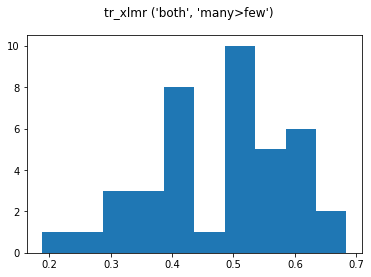

In [11]:
# r
plt.hist(measures[('both', 'many>few')])
plt.suptitle(PREFIX+' '+str(('both', 'many>few')))
measures.keys()

In [12]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
import dill

with open(f'{PREFIX}_baseline_scores.pkl', 'wb') as f:
    pickle.dump(scores, f, pickle.HIGHEST_PROTOCOL)
with open(f'{PREFIX}_baseline_stats.pkl', 'wb') as f:
    dill.dump(stats, f)
with open(f'{PREFIX}_baseline_measures.pkl', 'wb') as f:
    pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)        

In [19]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
import dill

with open(f'{PREFIX}_baseline_measures.pkl', 'rb') as f:
#     pickle.dump(measures, f, pickle.HIGHEST_PROTOCOL)        
    a = pickle.load(f)
a

{('both', 'aff>neg'): [0.636,
  0.964,
  0.576,
  0.568,
  0.684,
  0.664,
  0.548,
  0.604,
  0.412,
  0.588,
  0.612,
  0.432,
  0.768,
  0.456,
  0.548,
  0.484,
  0.548,
  0.5,
  0.3,
  0.452,
  0.576,
  0.588,
  0.592,
  0.528,
  0.6,
  0.584,
  0.784,
  0.564,
  0.932,
  0.632,
  0.628,
  0.44,
  0.708,
  0.68,
  0.536,
  0.608,
  0.648,
  0.54,
  0.592,
  0.668],
 ('both', 'many>few'): [0.38,
  0.796,
  0.708,
  0.504,
  0.352,
  0.544,
  0.408,
  0.452,
  0.408,
  0.52,
  0.572,
  0.392,
  0.424,
  0.692,
  0.66,
  0.328,
  0.64,
  0.368,
  0.452,
  0.448,
  0.492,
  0.42,
  0.412,
  0.376,
  0.668,
  0.8,
  0.472,
  0.6,
  0.48,
  0.612,
  0.548,
  0.348,
  0.372,
  0.332,
  0.268,
  0.352,
  0.484,
  0.64,
  0.52,
  0.584],
 ('thing', 'aff>neg'): [0.636,
  0.964,
  0.576,
  0.568,
  0.684,
  0.664,
  0.548,
  0.604,
  0.412,
  0.588,
  0.612,
  0.432,
  0.768,
  0.456,
  0.548,
  0.484,
  0.548,
  0.5,
  0.3,
  0.452,
  0.576,
  0.588,
  0.592,
  0.528,
  0.6,
  0.584,
  0.78

Text(0.5, 0.98, "fr_xlmr ('both', 'aff>neg')")

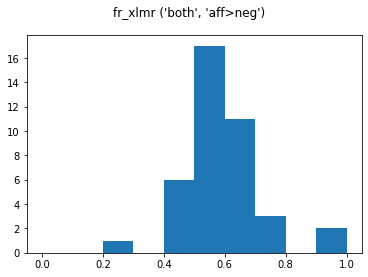

In [20]:
import matplotlib.pyplot as plt

plt.hist(a[('both', 'aff>neg')], range=(0,1))
plt.suptitle(PREFIX+' '+str(('both', 'aff>neg')))
